In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tempmatch as tm
import obspy

import helpers

In [2]:
day138 = helpers.import_raw_data_for_single_day('138', '2019', 'b')

In [3]:
day138.decimate(factor=10)
day138_original = day138.copy()

In [4]:
# https://docs.obspy.org/packages/autogen/obspy.signal.filter.bandpass.html#obspy.signal.filter.bandpass
day138.filter(freqmin=5, freqmax=10, corners=4, type='bandpass')

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.017000Z | 100.0 Hz, 8639812 samples
7F.B00.02.GDH | 2019-05-18T00:00:01.540000Z - 2019-05-19T00:00:00.840000Z | 100.0 Hz, 8639931 samples
7F.B00.03.GDH | 2019-05-18T00:00:02.689000Z - 2019-05-19T00:00:03.129000Z | 100.0 Hz, 8640045 samples
7F.B00.04.GDH | 2019-05-18T00:00:02.341000Z - 2019-05-19T00:00:01.081000Z | 100.0 Hz, 8639875 samples
7F.B00.05.GDH | 2019-05-18T00:00:02.971000Z - 2019-05-19T00:00:01.291000Z | 100.0 Hz, 8639833 samples
7F.B00.06.GDH | 2019-05-18T00:00:02.192000Z - 2019-05-19T00:00:01.372000Z | 100.0 Hz, 8639919 samples

In [5]:
day138.detrend('demean')

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.017000Z | 100.0 Hz, 8639812 samples
7F.B00.02.GDH | 2019-05-18T00:00:01.540000Z - 2019-05-19T00:00:00.840000Z | 100.0 Hz, 8639931 samples
7F.B00.03.GDH | 2019-05-18T00:00:02.689000Z - 2019-05-19T00:00:03.129000Z | 100.0 Hz, 8640045 samples
7F.B00.04.GDH | 2019-05-18T00:00:02.341000Z - 2019-05-19T00:00:01.081000Z | 100.0 Hz, 8639875 samples
7F.B00.05.GDH | 2019-05-18T00:00:02.971000Z - 2019-05-19T00:00:01.291000Z | 100.0 Hz, 8639833 samples
7F.B00.06.GDH | 2019-05-18T00:00:02.192000Z - 2019-05-19T00:00:01.372000Z | 100.0 Hz, 8639919 samples

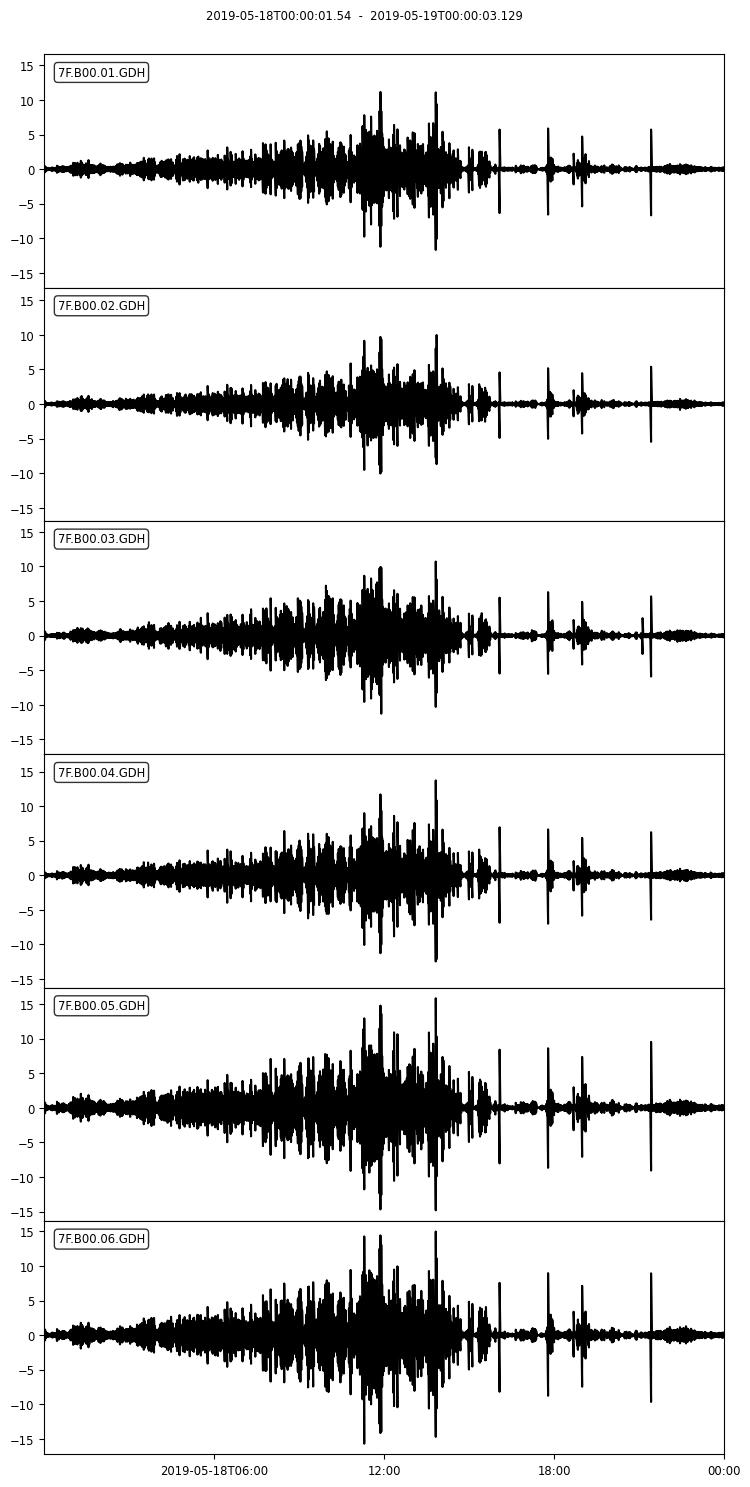

In [6]:
_ = day138.plot()

In [7]:
def square_data_in_stream(stream):
    for s in stream:
        s.data = s.data**2
    print('data has been squared')

square_data_in_stream(day138)

data has been squared


In [8]:
day138_original.max()

[39.898697167678549,
 33.100531891886618,
 42.279838049166443,
 44.988794118319717,
 38.321053824256467,
 32.221313340077771]

In [9]:
day138.max()

[136.34111283317512,
 100.96636884177869,
 127.38786187434388,
 188.27002505896044,
 250.99653600677203,
 246.40079336388425]

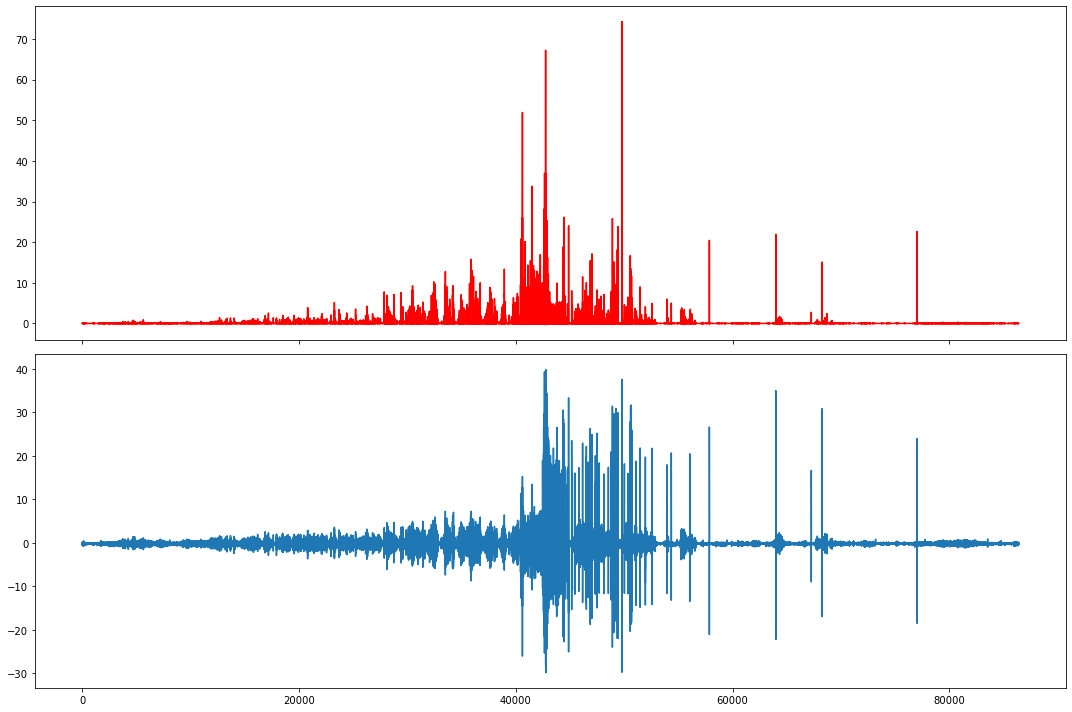

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

data = day138.copy()
# data.filter(type='lowpass', freq=0.01, zerophase=True)
data.filter(type='lowpass', freq=10, zerophase=True)

ax[0].plot(data[0].times(), data[0].data, color='red')
ax[1].plot(day138_original[0].times(), day138_original[0].data)

fig.tight_layout()

In [70]:
obspy.UTCDateTime('2019-05-18T11:00:00')

2019-05-18T11:00:00.000000Z

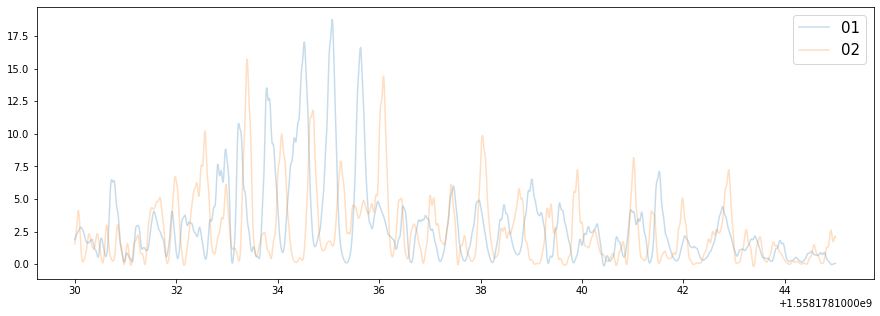

In [72]:
littlebits = data.slice(starttime=obspy.UTCDateTime('2019-05-18T11:15:30'), endtime=obspy.UTCDateTime('2019-05-18T11:15:45'))

fig, ax = plt.subplots(figsize=(15, 5))

for tr in littlebits[0:2]:
    x = tr.times('utcdatetime')
    y = tr.data
    ax.plot(x, y, label=tr.stats.location, alpha=0.25,)
ax.legend(fontsize=15)

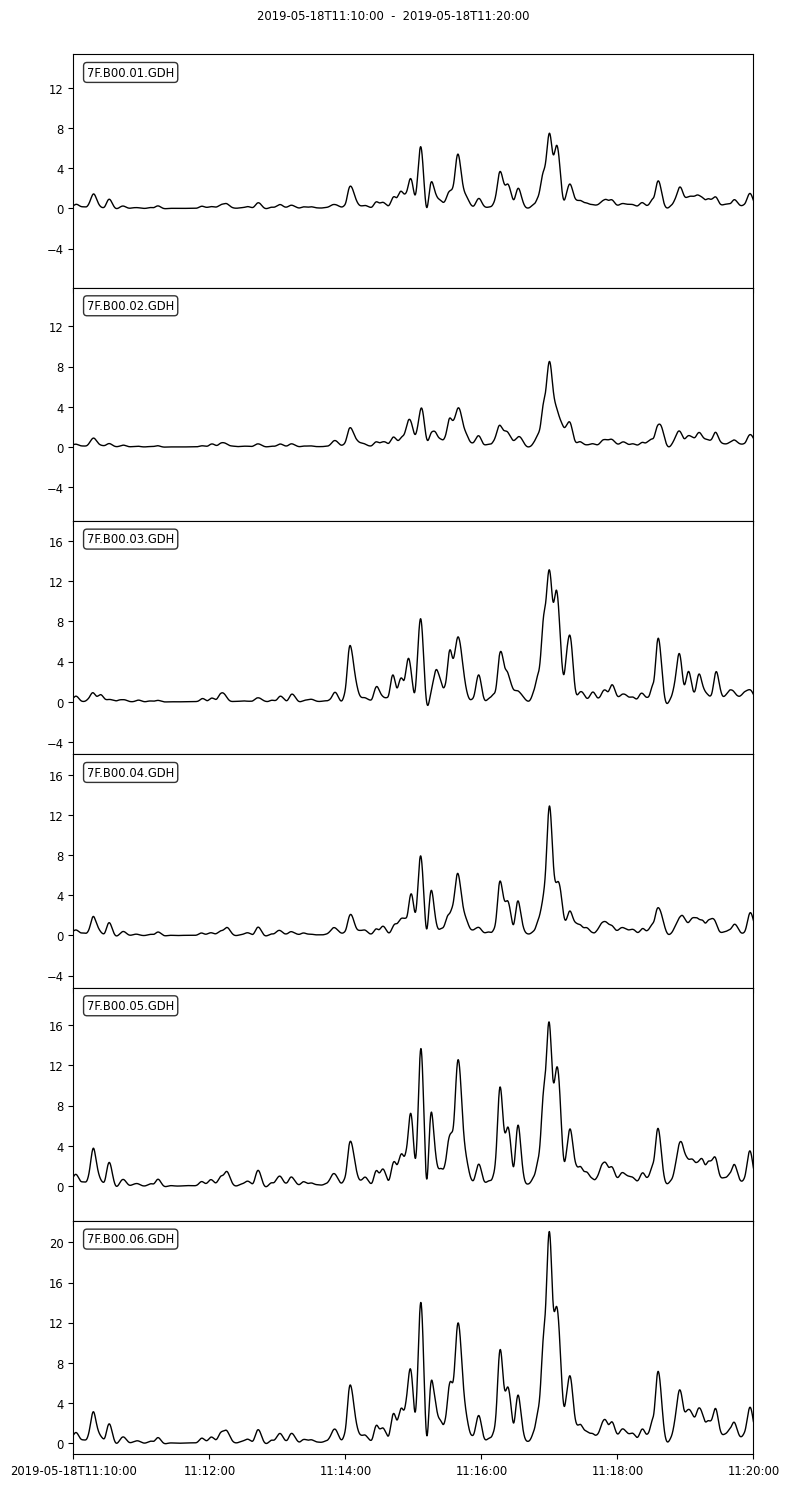

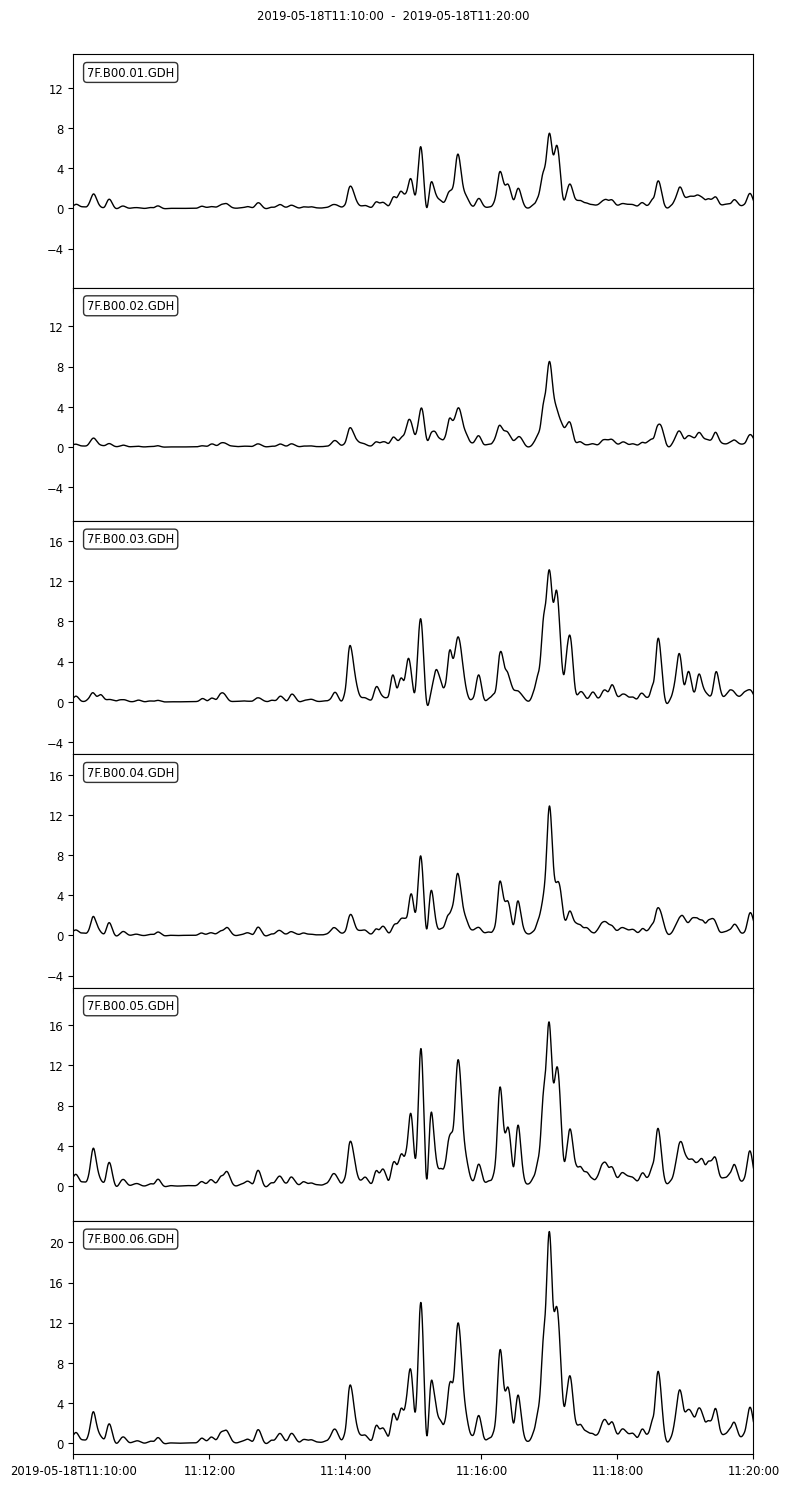

In [18]:
data.plot(starttime=obspy.UTCDateTime('2019-05-18T11:10:00'), endtime=obspy.UTCDateTime('2019-05-18T11:20:00'))

In [11]:
data[0].data[::100].shape

(86399,)

In [12]:
data[0].data.shape

(8639812,)

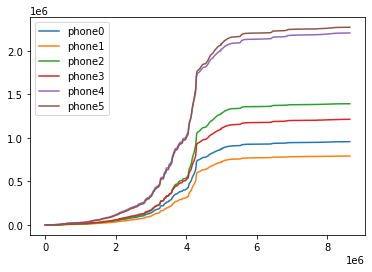

In [13]:
for n in [0, 1, 2, 3, 4, 5]:
    plt.plot(data[n].data.cumsum(), label='phone{n}'.format(n=n))
# plt.plot(data[5].data.cumsum())
plt.legend()

In [14]:
import itertools

hydrophones = [0, 1, 2, 3, 4, 5]
hydrophone_pairs = [h for h in itertools.combinations(hydrophones, 2)]
hydrophone_pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

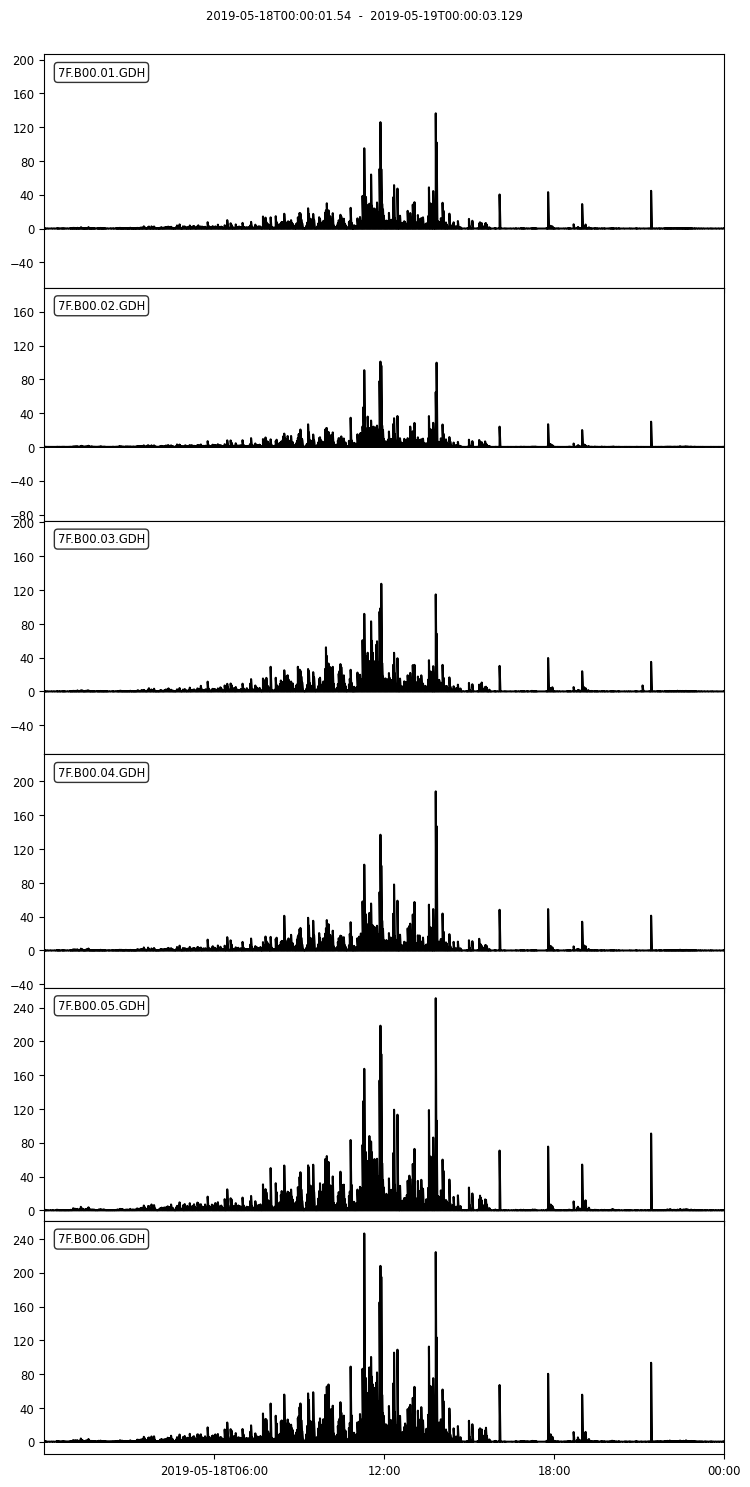

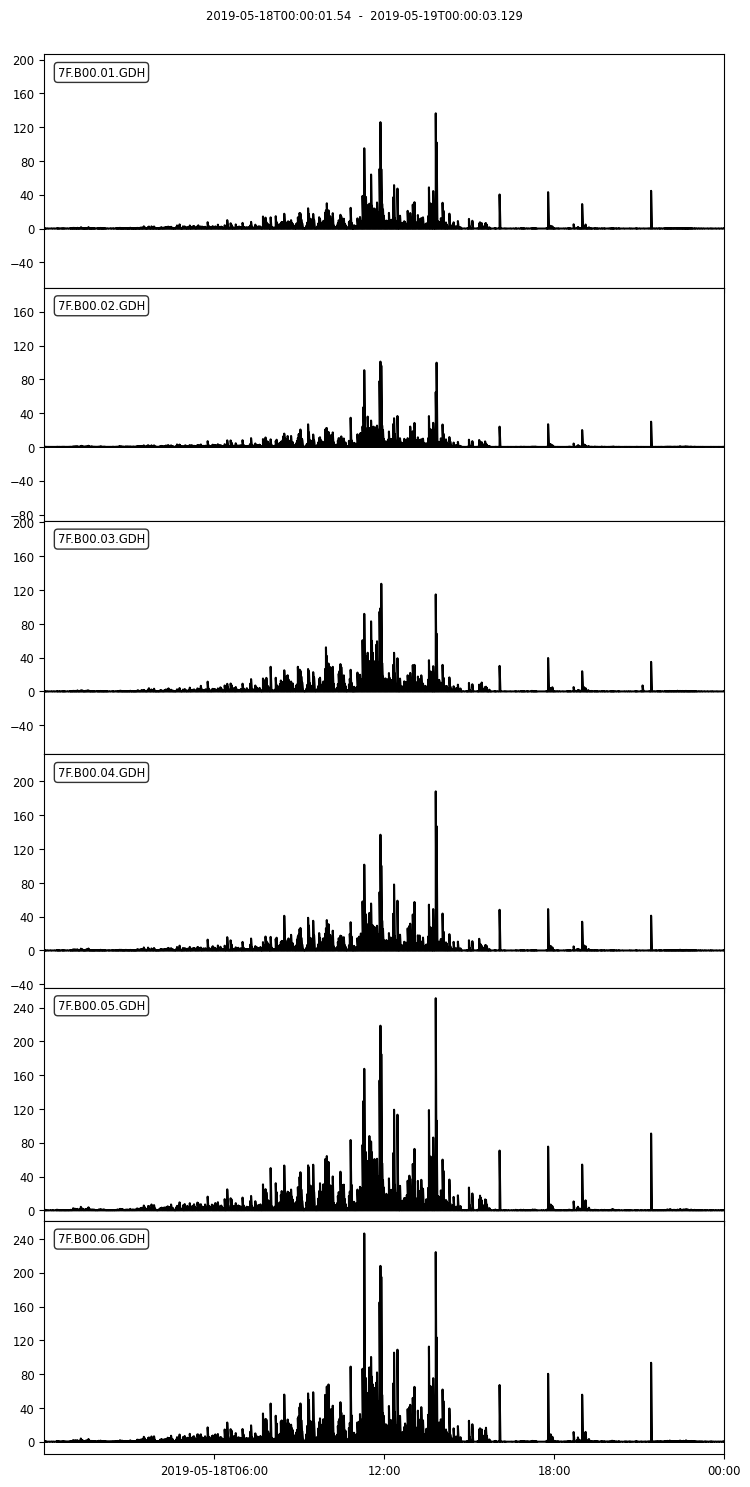

In [133]:
day138.plot()

In [121]:
cc_df = pd.DataFrame()

data = day138.copy()
data.filter('lowpass', freq=0.01)
day138_windows = day138.copy().filter('lowpass', freq=0.01).slide(window_length=5*60.0, step=5*60.0,)

n = -1
for window in day138_windows:
    # print(window[0].stats)
    # print(window)
    n+=1
    for pair in hydrophone_pairs:
        h1, h2 = pair
        cc = obspy.signal.cross_correlation.correlate(a=window[h1]
                                                      , b=window[h2]
                                                      , shift=100*5
                                                      , demean=True
                                                      , normalize=True)

        window_df = pd.DataFrame(
            {
                'window_index':[n,]
                ,'h1_index':(h1,) # first hydrophone index used for cross correlation
                , 'h2_index':(h2,) # second hydrophone index used for cross correlation
                ,'cross_correlation_max':[cc.max(),]
                ,'cross_correlation_index':[np.argmax(cc),]
                ,'sample_rate':[window[0].stats.sampling_rate,]
                ,'window_starttime':[window[0].stats.starttime,]
                ,'window_endtime':[window[0].stats.endtime]
                ,'lagtime_seconds':((np.argmax(cc)-500)*1/100.,)
                ,'cc_estimator':(cc,)
            }
        )
        cc_df = pd.concat([cc_df, window_df])
cc_df.reset_index(inplace=True)
cc_df.head()

,index,window_index,h1_index,h2_index,cross_correlation_max,cross_correlation_index,sample_rate,window_starttime,window_endtime,lagtime_seconds,cc_estimator
0,0,0,0,1,0.979889,568,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,0.68,"[0.93376666463, 0.933890885812, 0.934014963993..."
1,0,0,0,2,0.941224,518,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,0.18,"[0.883664663518, 0.883813964239, 0.88396312838..."
2,0,0,0,3,0.984401,528,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,0.28,"[0.955932894641, 0.956028700688, 0.95612435096..."
3,0,0,0,4,0.998294,497,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,-0.03,"[0.96362648535, 0.963736120183, 0.963845596772..."
4,0,0,0,5,0.999104,536,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,0.36,"[0.960665410019, 0.960780036755, 0.96089450856..."


<AxesSubplot:>

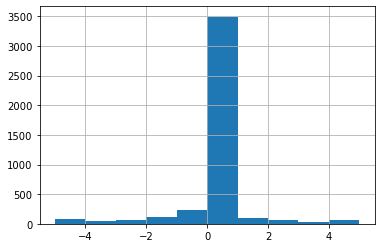

In [122]:
# cc_df.lagtime_seconds.hist(bins=np.linspace(-0.5, 0.5, 25))
cc_df.lagtime_seconds.hist()

In [123]:
cc_df.describe()

,index,window_index,h1_index,h2_index,cross_correlation_max,cross_correlation_index,sample_rate,lagtime_seconds
count,4320.0,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.0,4320.000000
mean,0.0,143.500000,1.333333,3.666667,0.969121,495.887500,100.0,-0.041125
std,0.0,83.147562,1.247364,1.247364,0.062443,118.065504,0.0,1.180655
min,0.0,0.000000,0.000000,1.000000,0.073725,0.000000,100.0,-5.000000
25%,0.0,71.750000,0.000000,3.000000,0.968133,500.000000,100.0,0.000000
50%,0.0,143.500000,1.000000,4.000000,0.989909,500.000000,100.0,0.000000
75%,0.0,215.250000,2.000000,5.000000,0.997141,500.000000,100.0,0.000000
max,0.0,287.000000,4.000000,5.000000,0.999998,1000.000000,100.0,5.000000


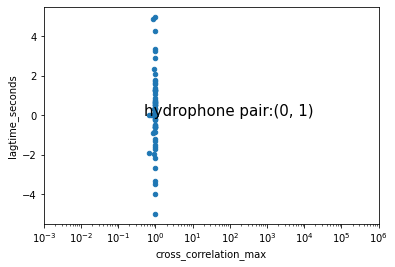

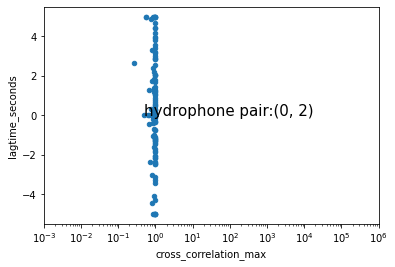

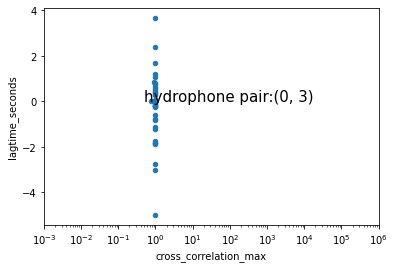

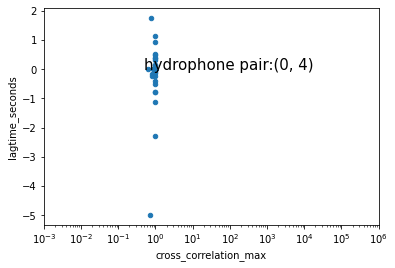

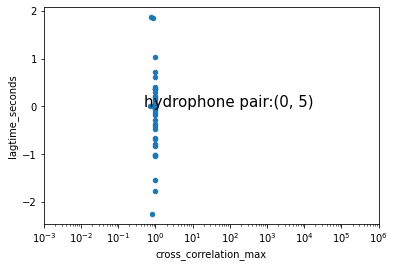

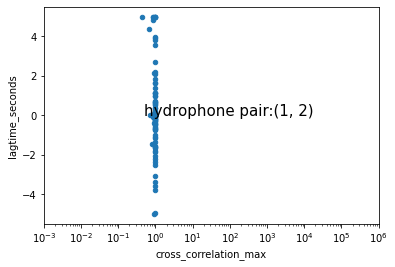

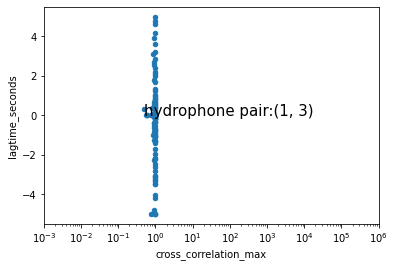

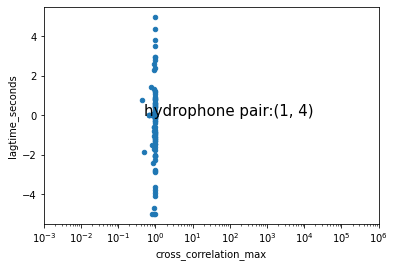

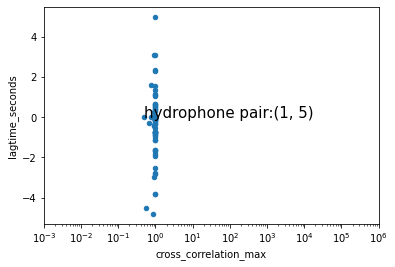

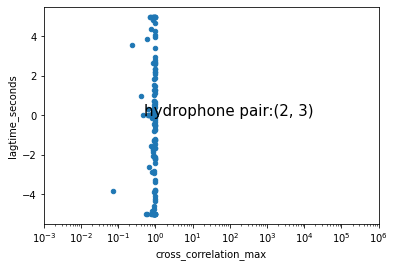

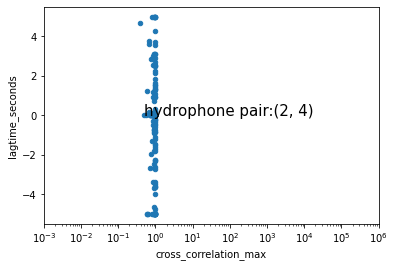

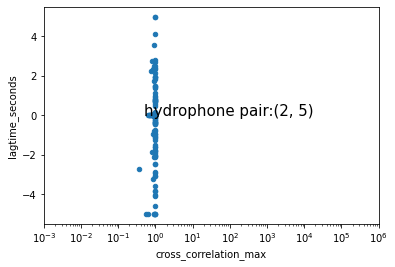

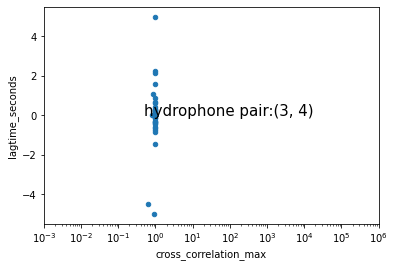

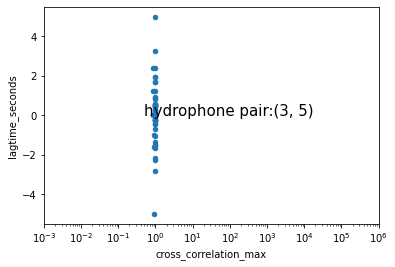

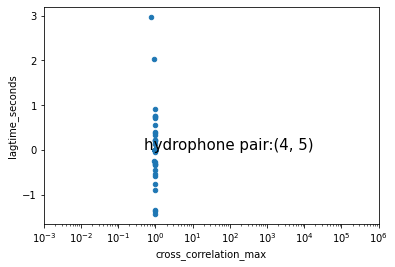

In [124]:
for pair in hydrophone_pairs:
    h1, h2 = pair
    ax = cc_df[(cc_df.h1_index==h1) & (cc_df.h2_index==h2)].plot.scatter(x='cross_correlation_max', y='lagtime_seconds')
    ax.text(s='hydrophone pair:'+str(pair), x=0.5, y=0, fontsize=15)
    ax.set_xscale('log')
    ax.set_xlim(1e-3, 1e6)

[Text(0, 0.0, '2019-05-18T00:00:02.907000Z'),
 Text(0, 10.0, '2019-05-18T01:35:01.537000Z'),
 Text(0, 20.0, '2019-05-18T03:10:01.537000Z'),
 Text(0, 30.0, '2019-05-18T04:45:01.537000Z'),
 Text(0, 40.0, '2019-05-18T06:20:01.537000Z'),
 Text(0, 50.0, '2019-05-18T07:55:01.537000Z'),
 Text(0, 60.0, '2019-05-18T09:30:01.537000Z'),
 Text(0, 70.0, '2019-05-18T11:05:01.537000Z'),
 Text(0, 80.0, '2019-05-18T12:40:01.537000Z'),
 Text(0, 90.0, '2019-05-18T14:15:01.537000Z'),
 Text(0, 100.0, '2019-05-18T15:50:01.537000Z'),
 Text(0, 110.0, '2019-05-18T17:25:01.537000Z'),
 Text(0, 120.0, '2019-05-18T19:00:01.537000Z'),
 Text(0, 130.0, '2019-05-18T20:35:01.537000Z'),
 Text(0, 140.0, '2019-05-18T22:10:01.537000Z')]

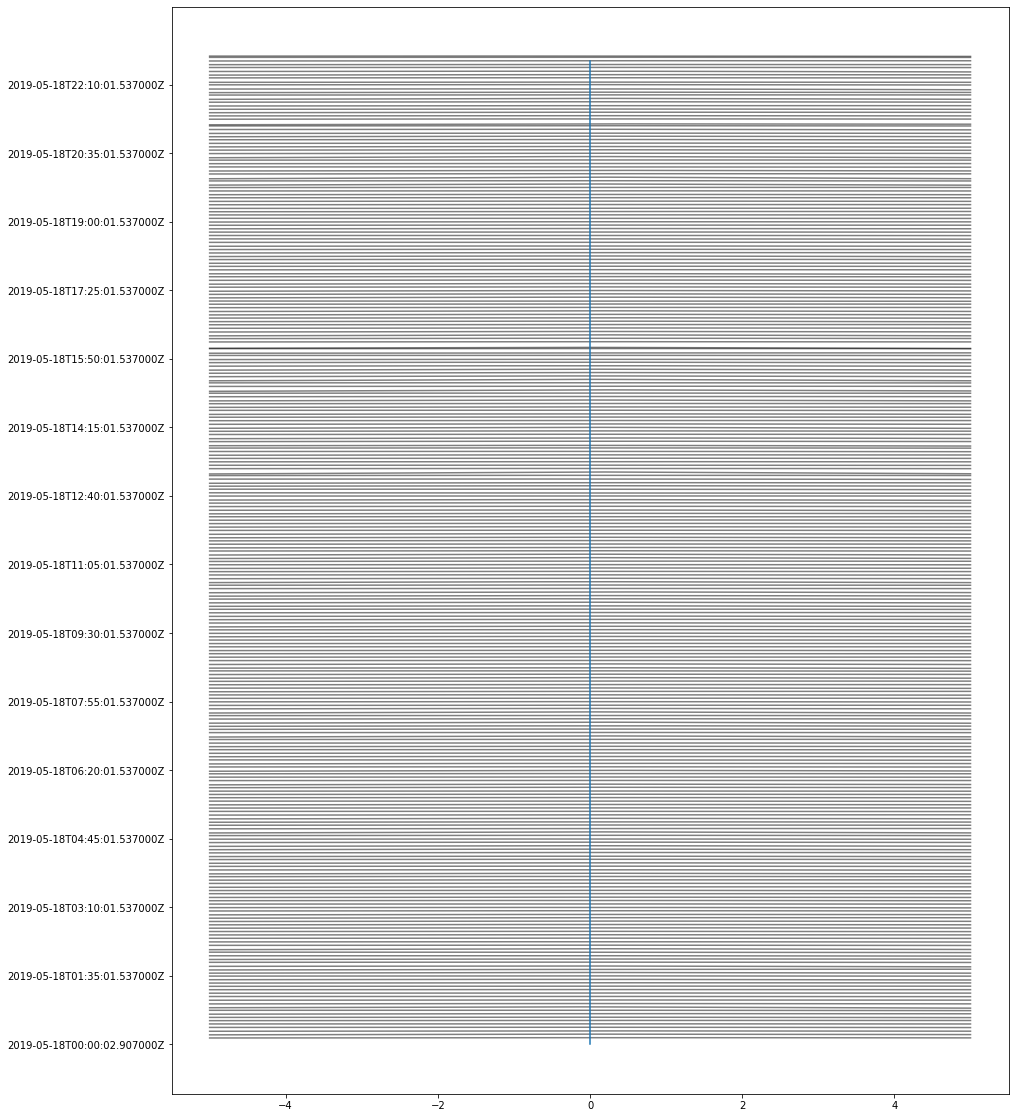

In [125]:
fig, ax = plt.subplots(figsize=(15, 20))

data = cc_df[(cc_df.h1_index==0) & (cc_df.h2_index==1)]

for n, cc in enumerate(data.cc_estimator.values):
    n = n * 0.5
    x = np.linspace(-5, 5, cc.shape[0])
    ax.plot(x, cc+n, color='black', alpha=0.5)
    
ax.plot([0, 0], [0, n])
ax.set_yticks(np.arange(0, n, 10))
ax.set_yticklabels(data.window_starttime[::19][:-1])

(-2.0, 2.0)

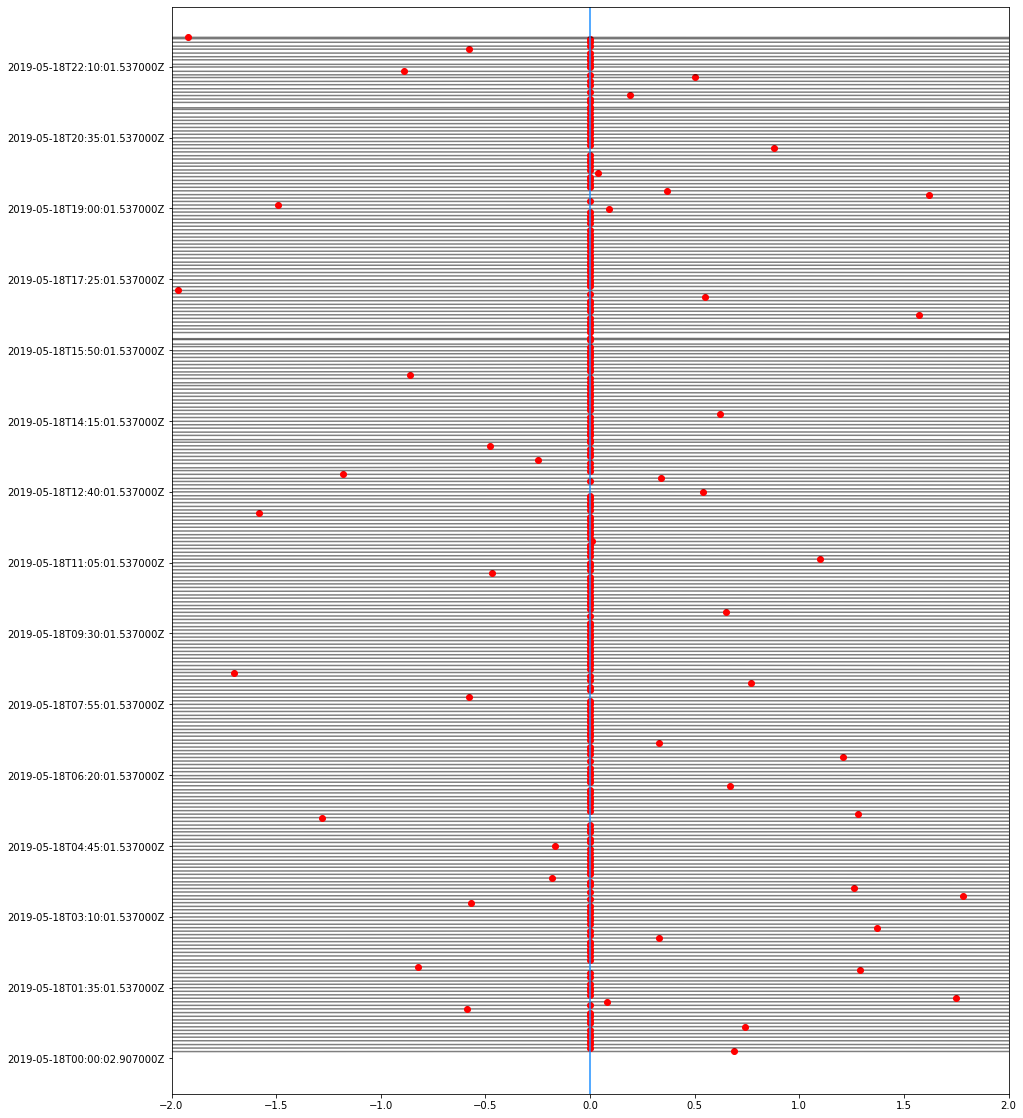

In [126]:
fig, ax = plt.subplots(figsize=(15, 20))

data = cc_df[(cc_df.h1_index==0) & (cc_df.h2_index==1)]

for n, cc in enumerate(data.cc_estimator.values):
    n = n * 0.5
    x = np.linspace(-5, 5, cc.shape[0])
    ax.plot(x, cc+n, color='black', alpha=0.5)
    ax.plot((x[np.argmax(cc)],), (cc.max()+n,), marker='o', color='red')
    
ax.plot([0, 0], [-5, n+5], color='dodgerblue')
ax.set_ylim(-5, n+5)
ax.set_yticks(np.arange(0, n, 10))
ax.set_yticklabels(data.window_starttime[::19][:-1])
ax.set_xlim(-2, 2)

In [127]:
hydrophone_pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

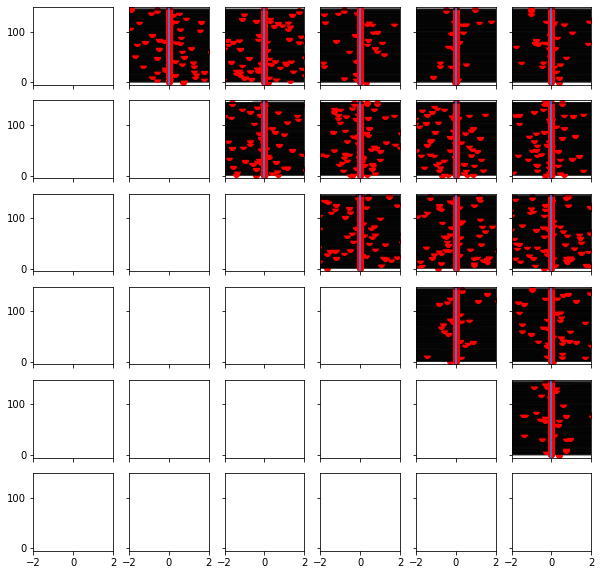

In [129]:
fig, ax = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)

for pairs in hydrophone_pairs:
    # fig, ax = plt.subplots(figsize=(15, 20))
    h1, h2 = pairs
    data = cc_df[(cc_df.h1_index==h1) & (cc_df.h2_index==h2)]

    for n, cc in enumerate(data.cc_estimator.values):
        n = n * 0.5
        x = np.linspace(-5, 5, cc.shape[0])
        ax[h1][h2].plot(x, cc+n, color='black', alpha=0.5)
        ax[h1][h2].plot((x[np.argmax(cc)],), (cc.max()+n,), marker='o', color='red')

    ax[h1][h2].plot([0, 0], [-5, n+5], color='dodgerblue')
    ax[h1][h2].set_ylim(-5, n+5)
    # ax[h1][h2].set_yticks(np.arange(0, n, 10))
    # ax[h1][h2].set_yticklabels(data.window_starttime[::19][:-1])
    ax[h1][h2].set_xlim(-2, 2)
    
    # ax[h1][h2].text(s='hydrophone pairs {pairs}'.format(pairs=str([p+1 for p in pairs]))
            # ,x=0.75, y=-4, fontsize=15 )

In [131]:
# data = cc_df[(cc_df.h1_index==0) & (cc_df.h2_index==1)].cc_estimator.values

# times = np.zeros_like(data[0])
# for t in data:
#     times += t
    
# times

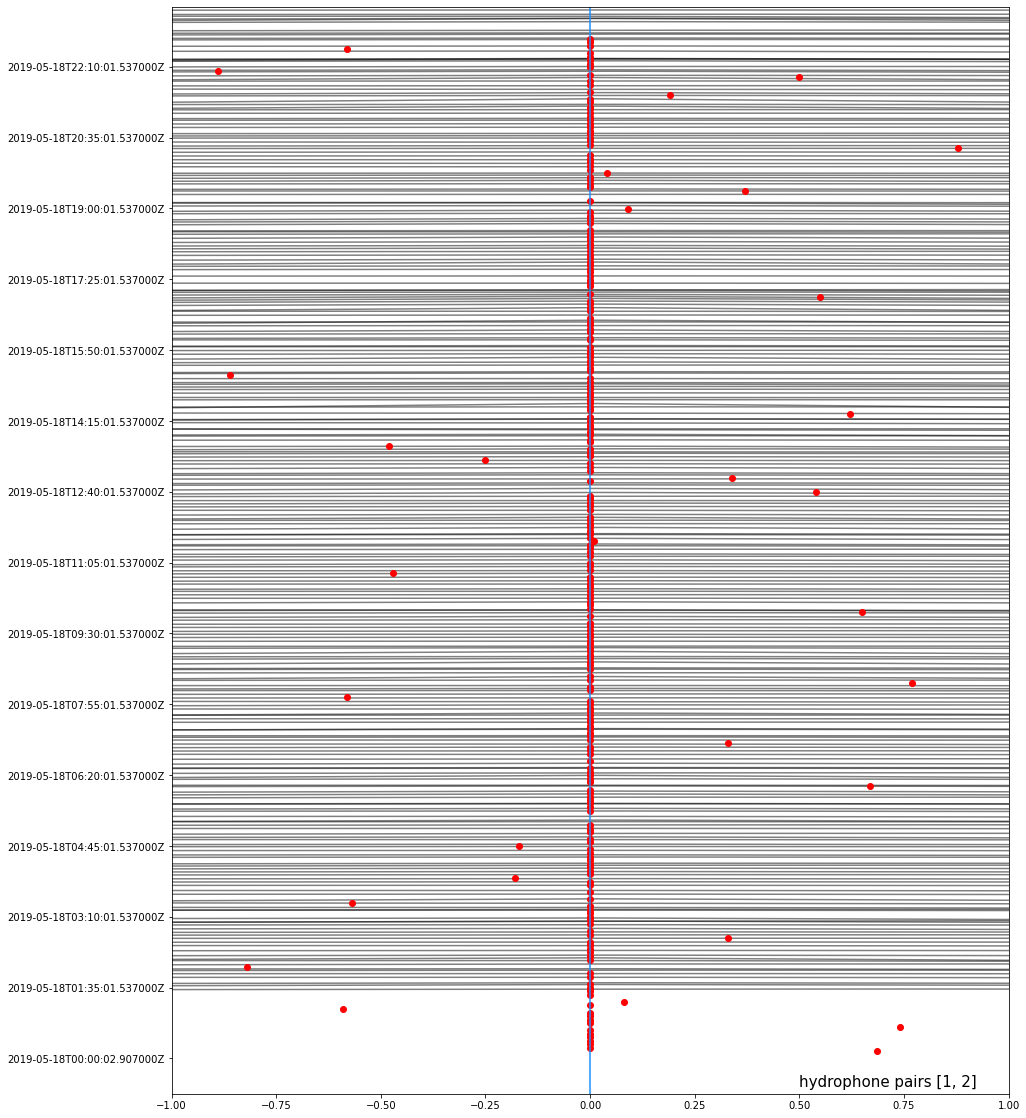

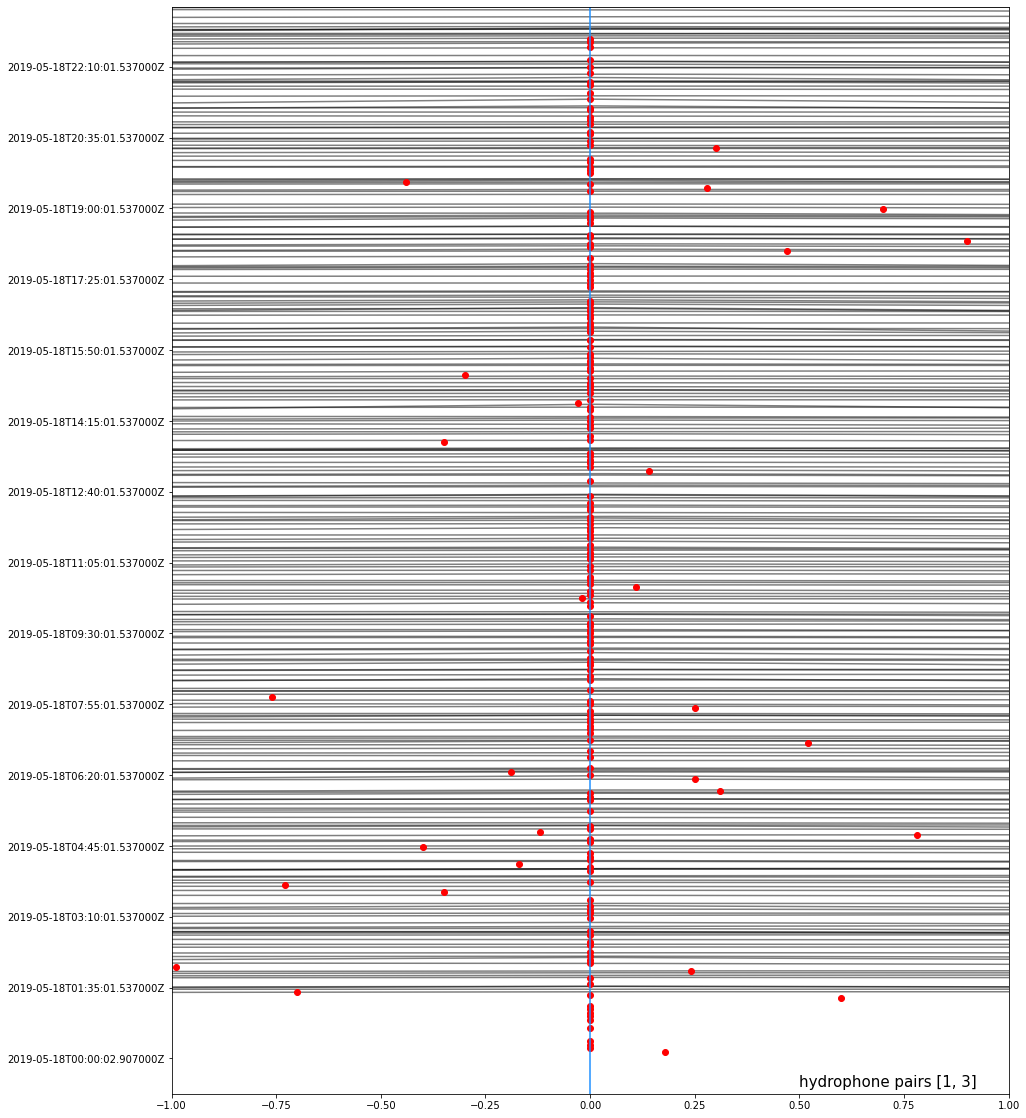

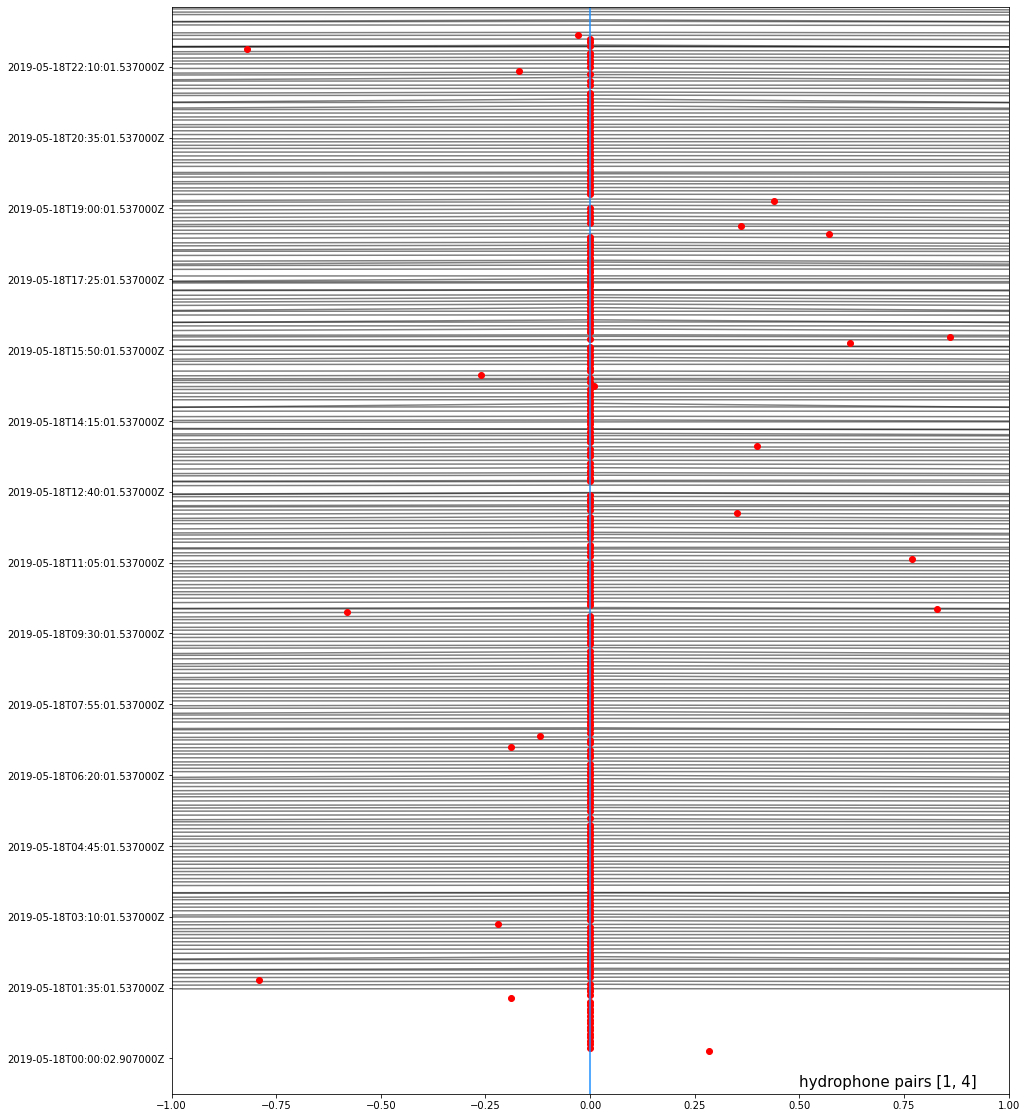

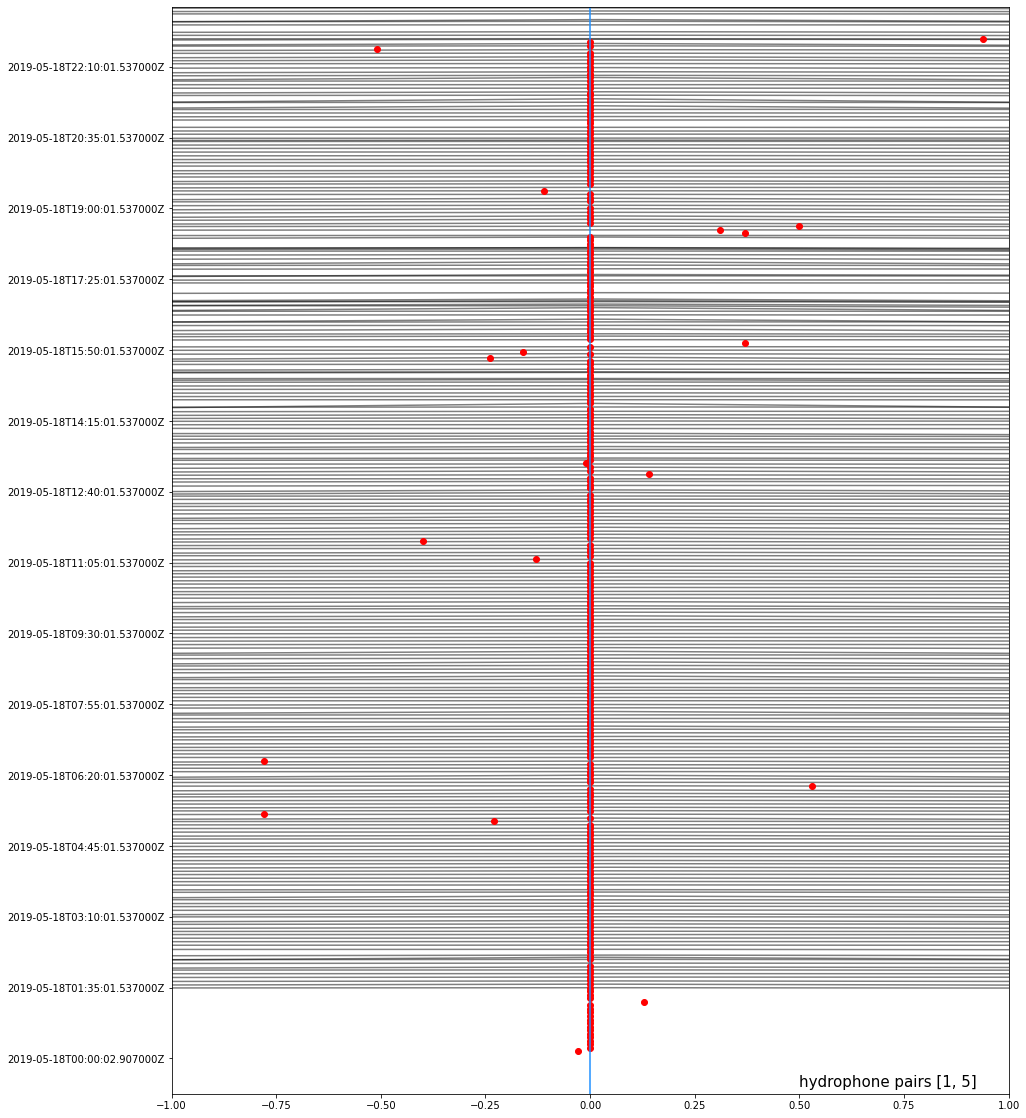

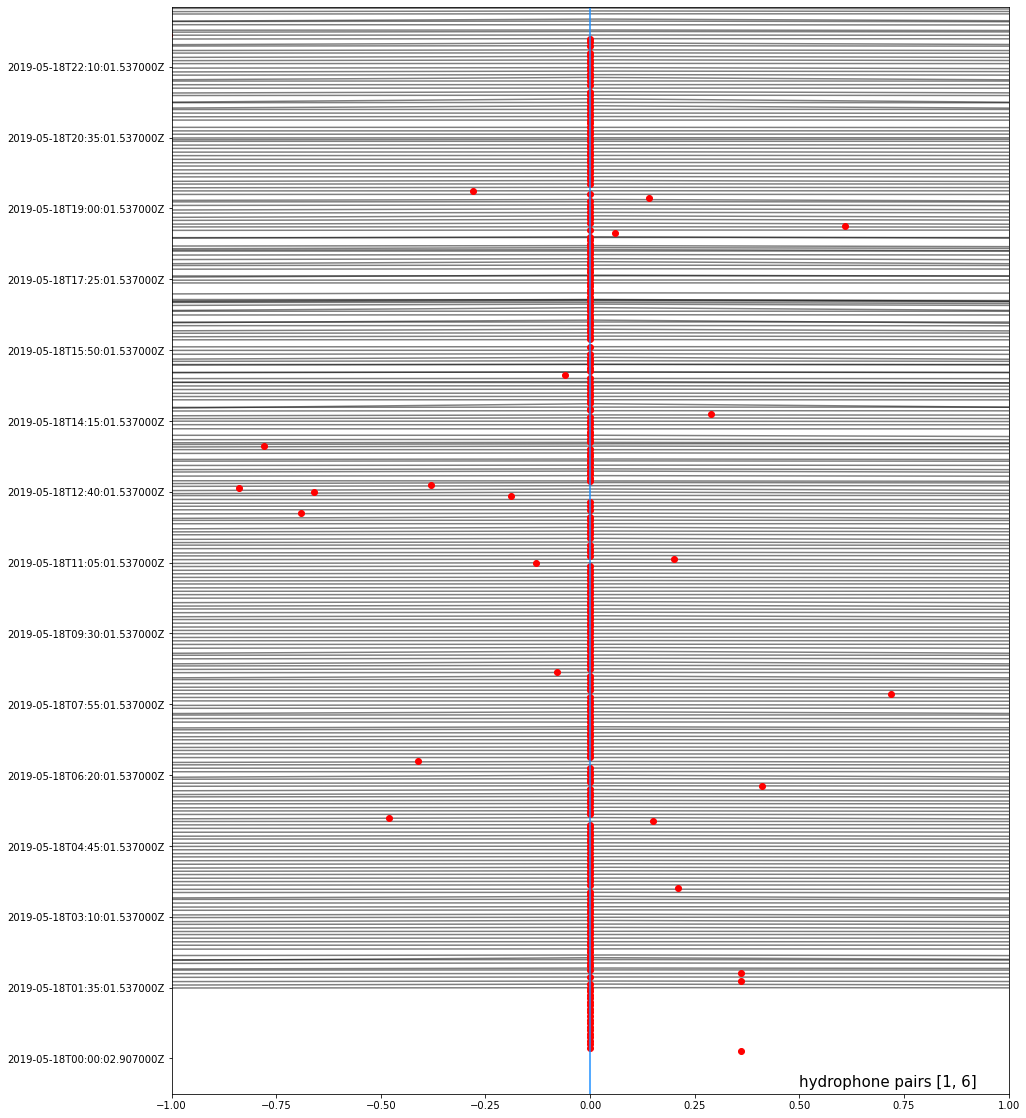

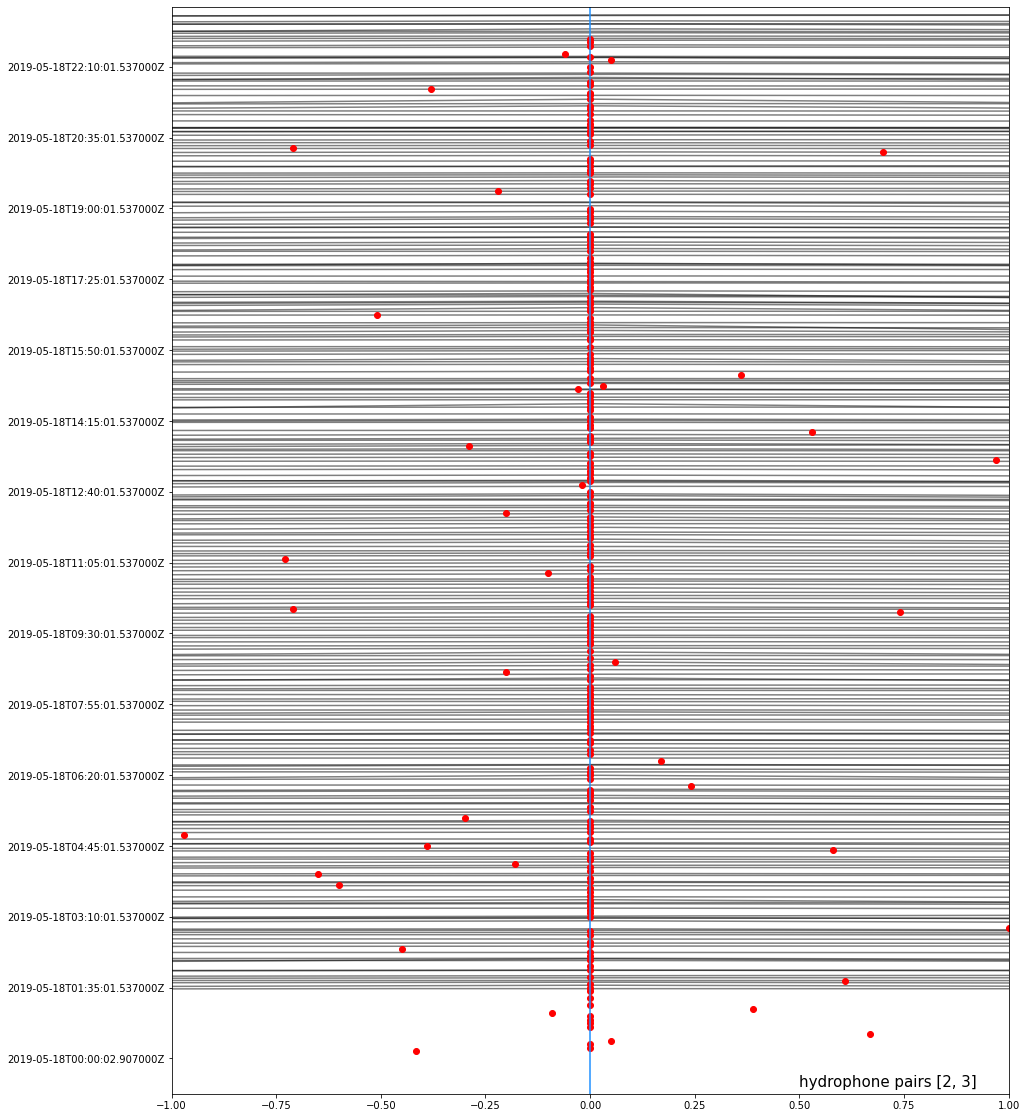

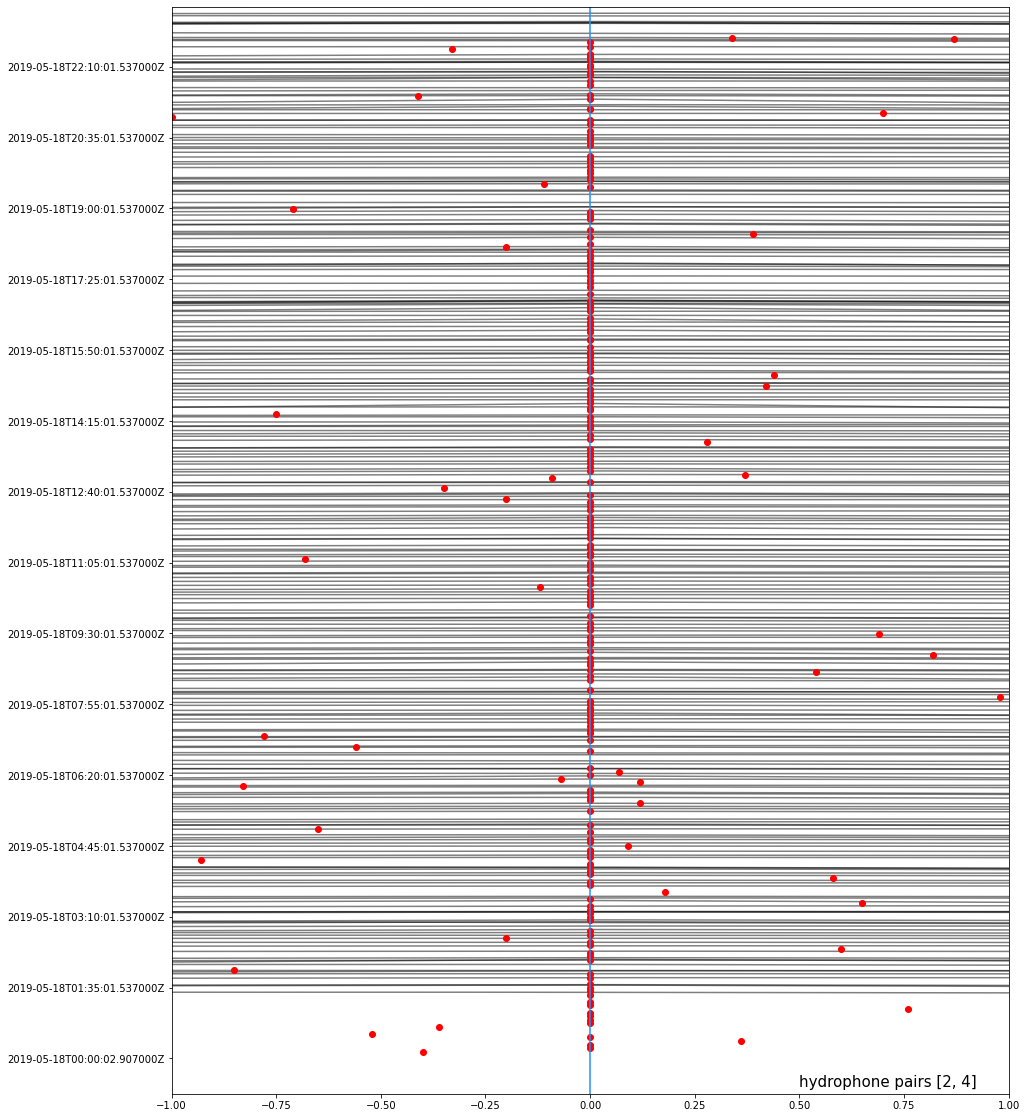

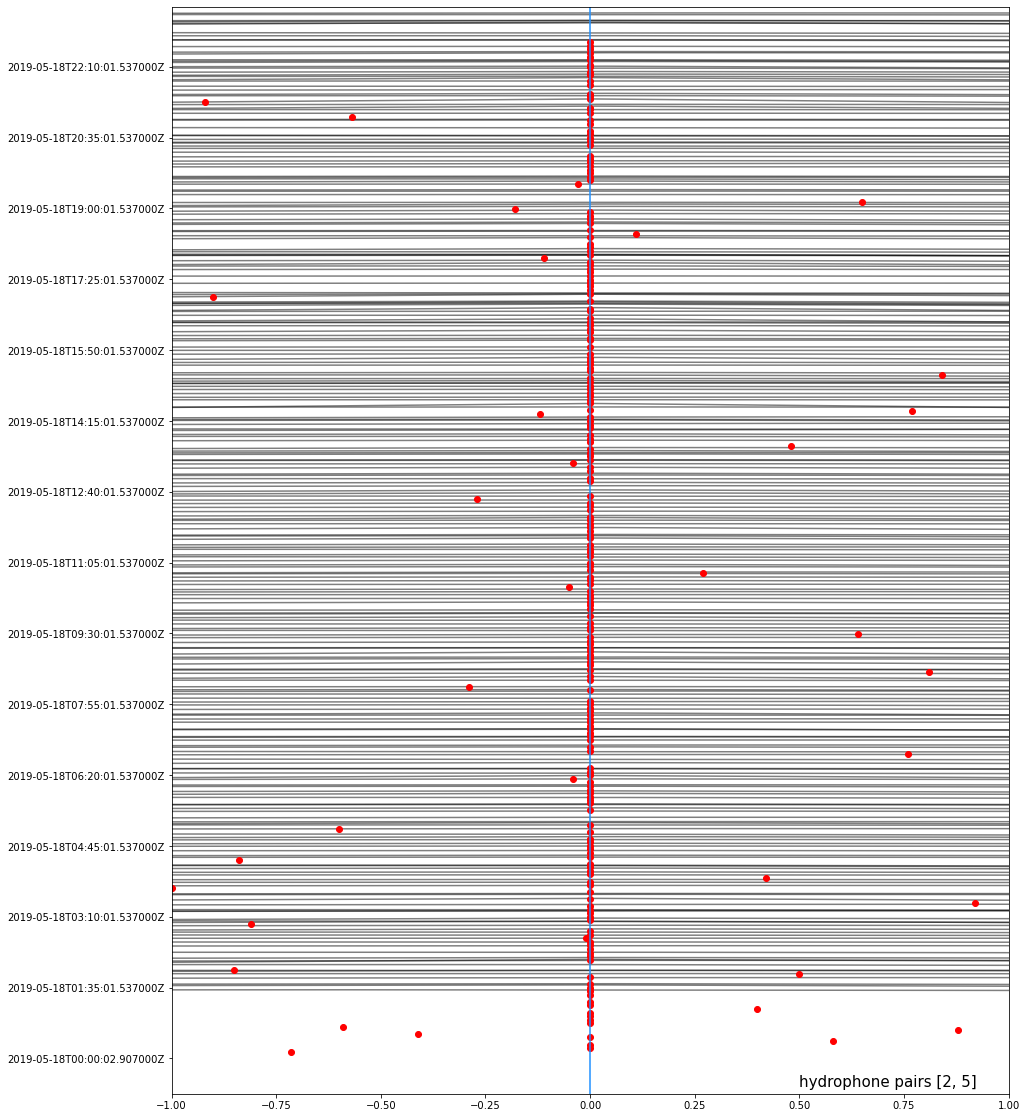

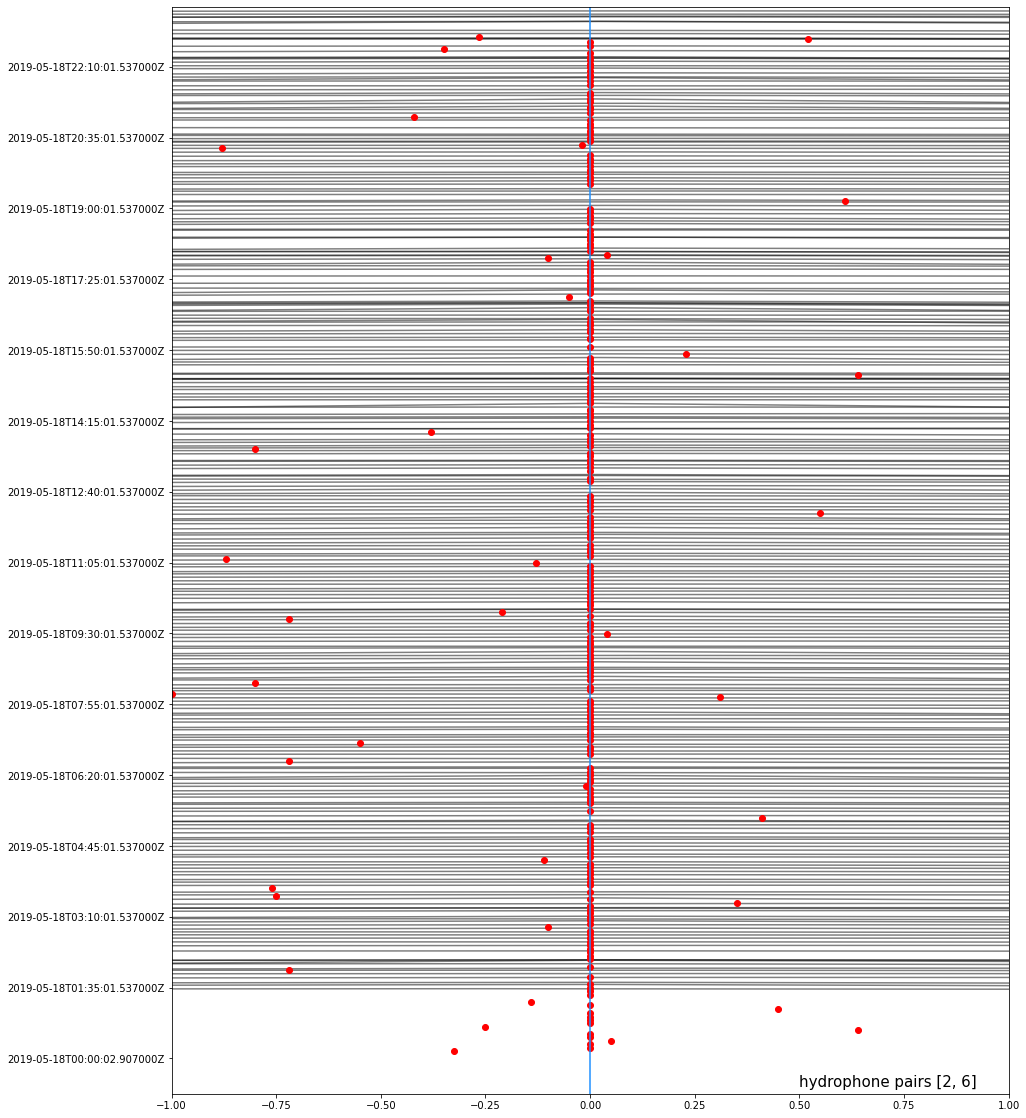

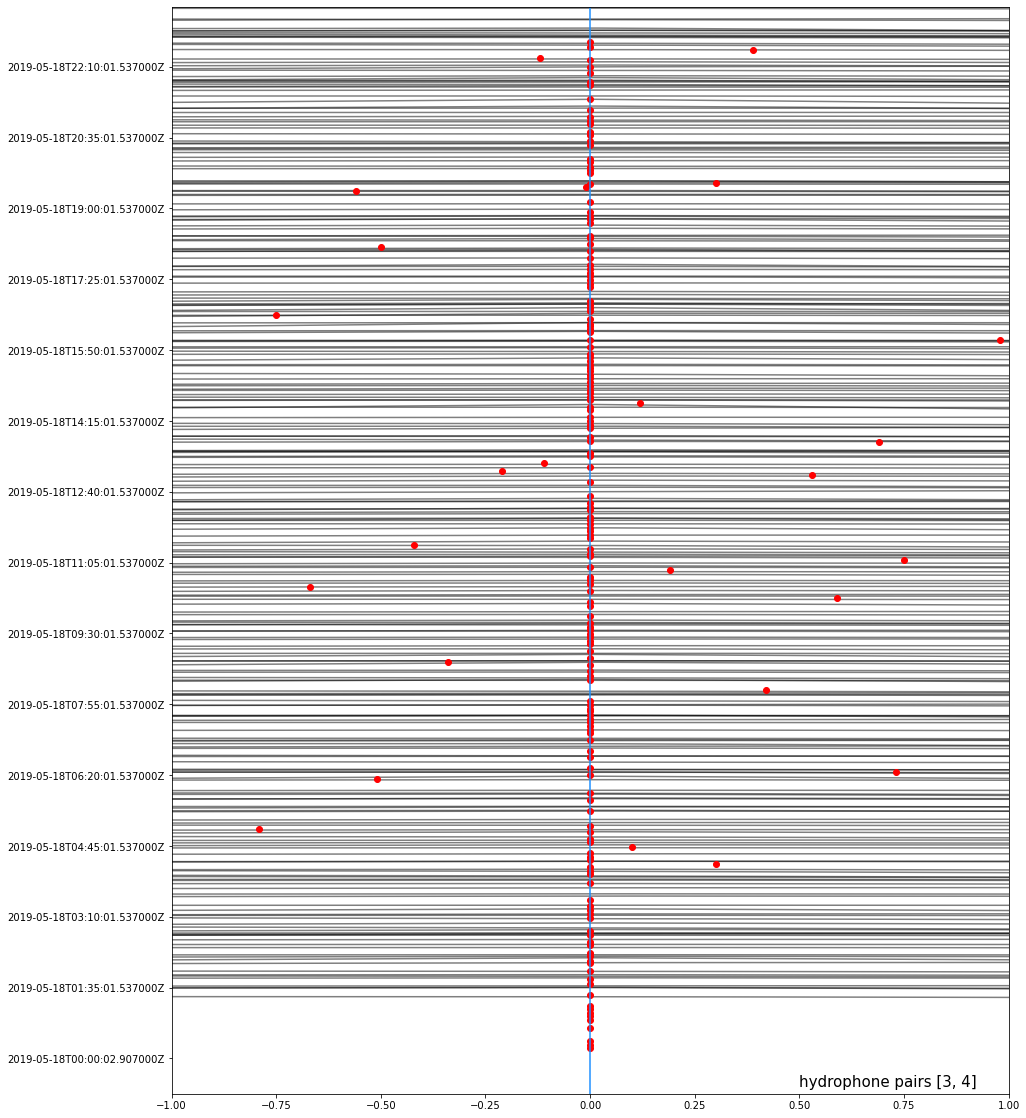

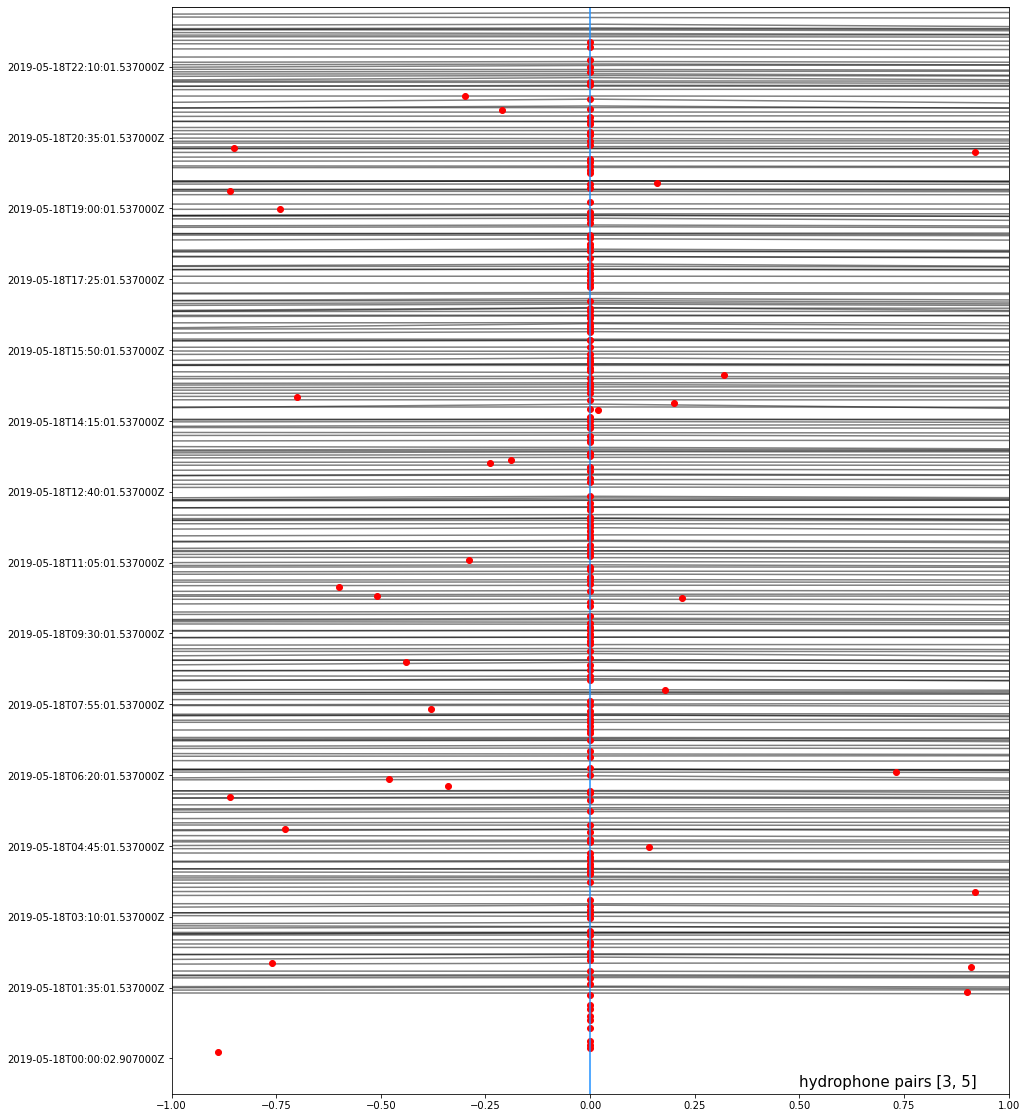

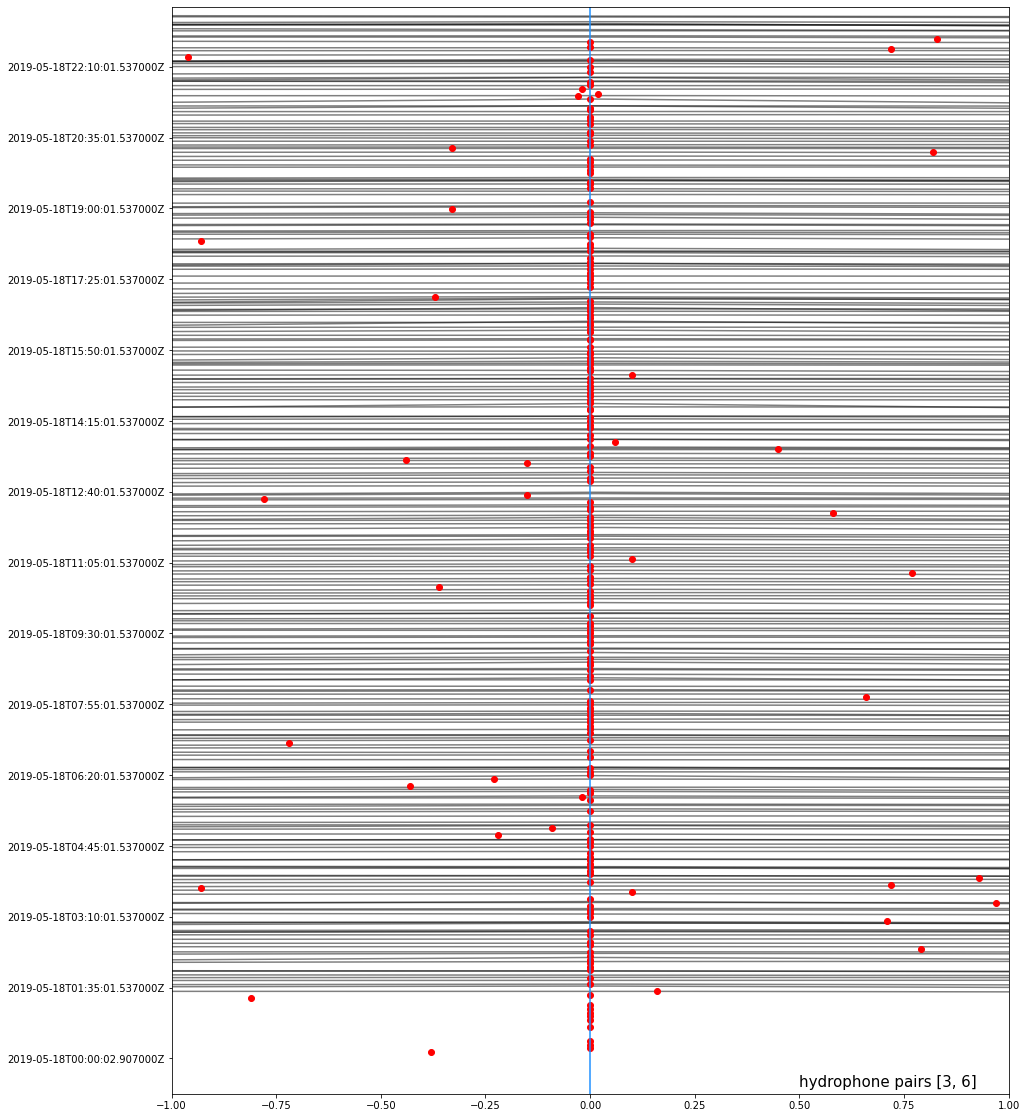

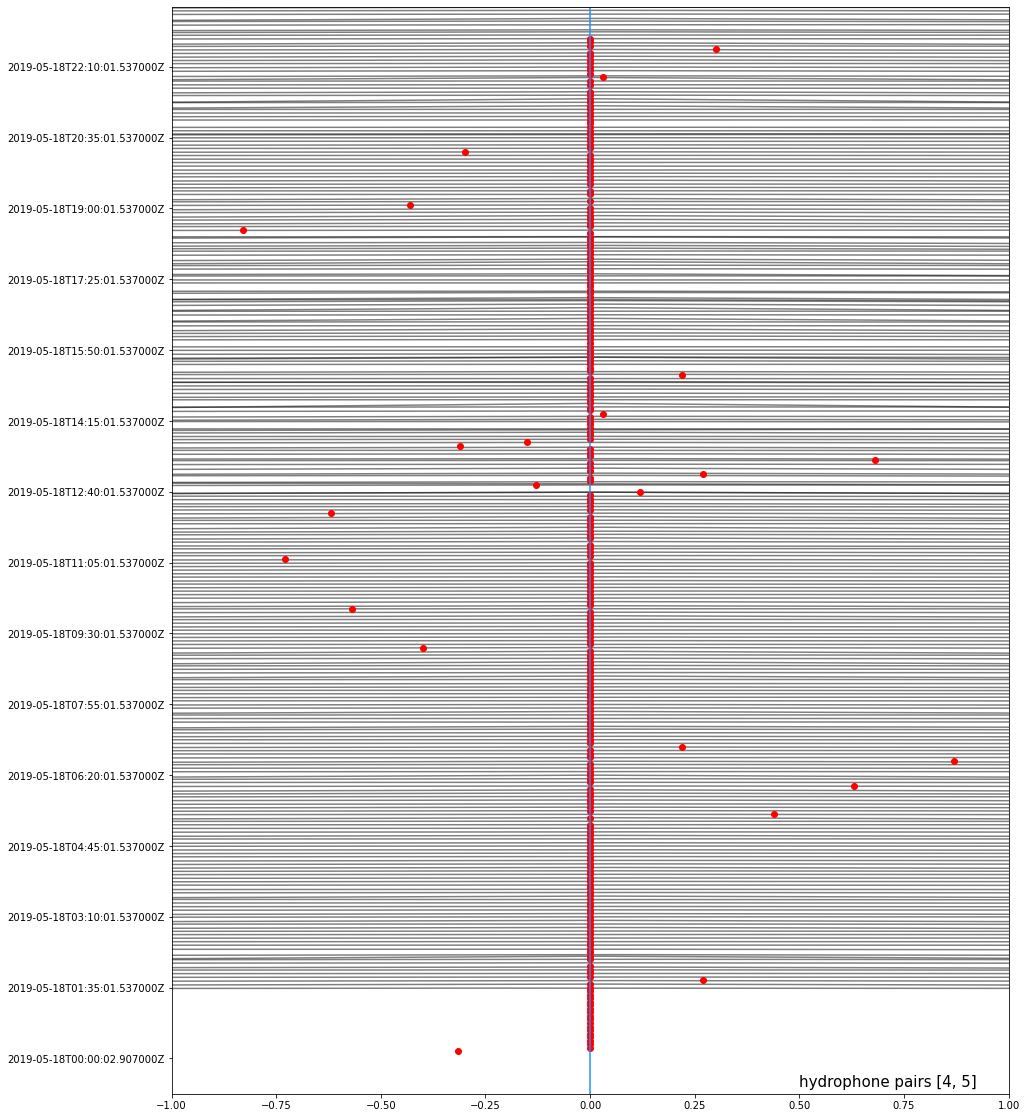

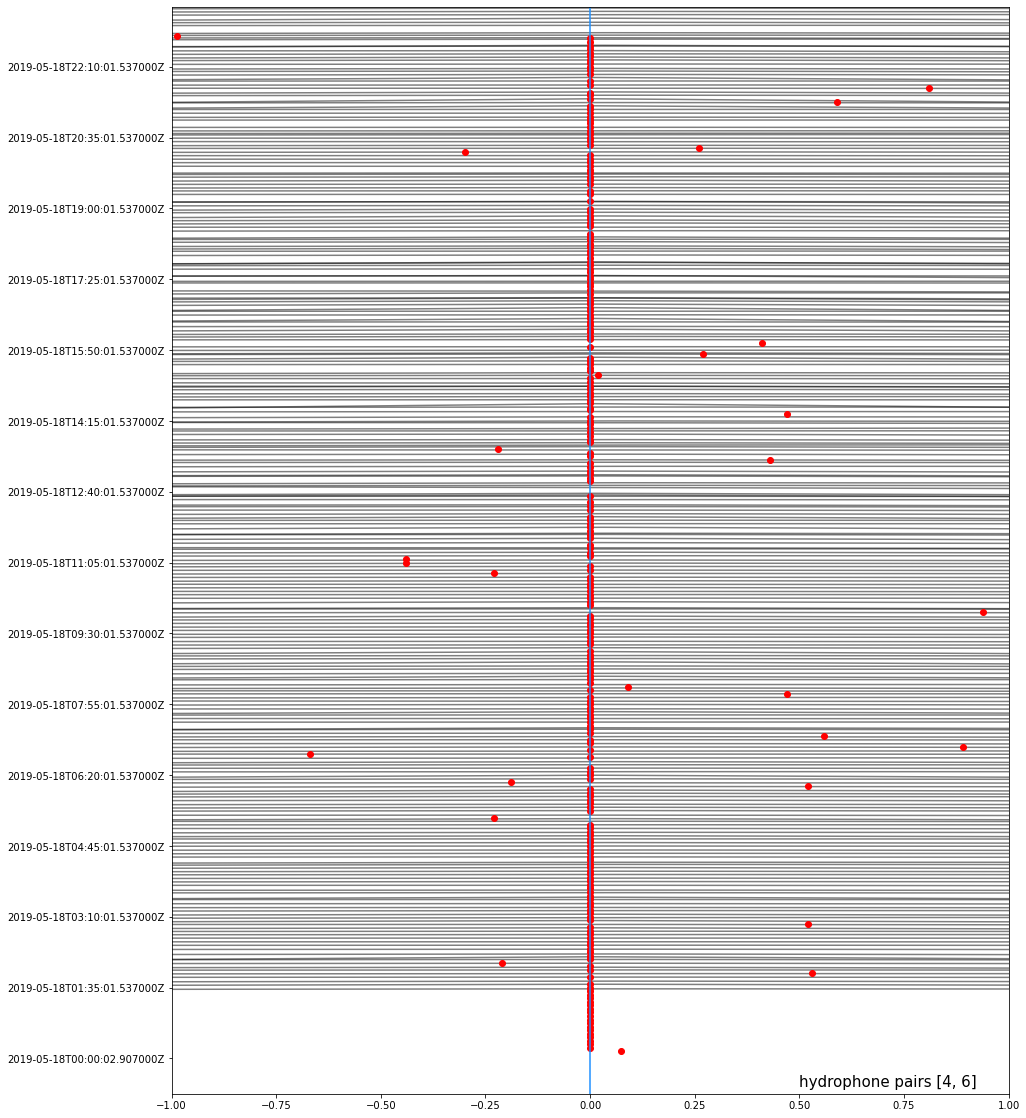

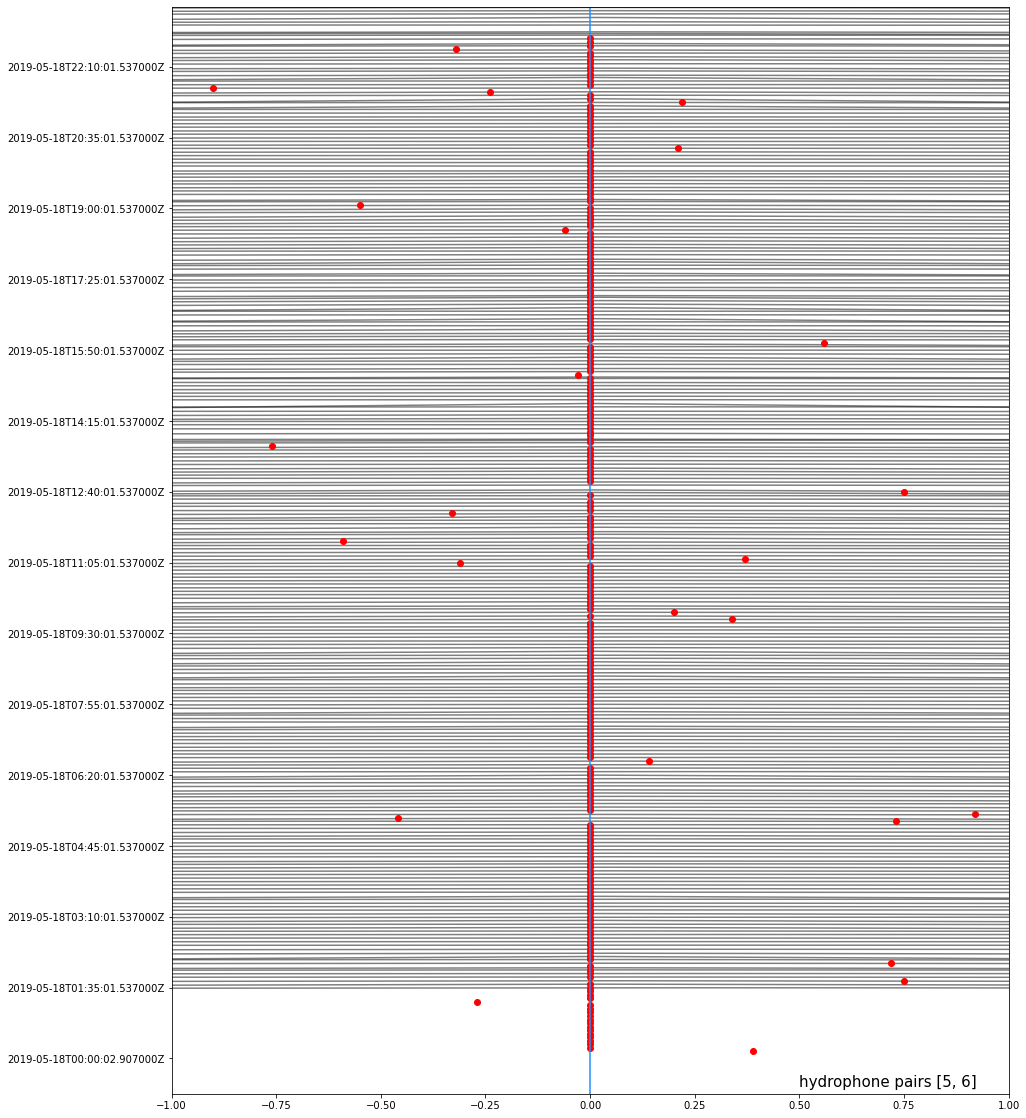

In [132]:
for pairs in hydrophone_pairs:
    fig, ax = plt.subplots(figsize=(15, 20))
    h1, h2 = pairs
    data = cc_df[(cc_df.h1_index==h1) & (cc_df.h2_index==h2)]

    for n, cc in enumerate(data.cc_estimator.values):
        n = n * 0.5
        x = np.linspace(-5, 5, cc.shape[0])
        ax.plot(x, (cc*10+n), color='black', alpha=0.5)
        ax.plot((x[np.argmax(cc)],), (cc.max()+n,), marker='o', color='red')

    ax.plot([0, 0], [-5, n+5], color='dodgerblue')
    ax.set_ylim(-5, n+5)
    ax.set_yticks(np.arange(0, n, 10))
    ax.set_yticklabels(data.window_starttime[::19][:-1])
    ax.set_xlim(-1, 1)
    
    ax.text(s='hydrophone pairs {pairs}'.format(pairs=str([p+1 for p in pairs]))
            ,x=0.5, y=-4, fontsize=15 )

In [ ]:
29864/100

In [ ]:
469 10s of ms


In [ ]:
# filelocs = !ls /media/sda/data/robdata/tremors/*.mseed

In [ ]:
# stream = obspy.read(filelocs[0])
# for f in filelocs[1:]:
#     stream = stream + obspy.read(f)

In [ ]:
# stream.merge()

In [ ]:
# stream